In [1]:
import pandas as pd
df = pd.read_csv('CRSP_Updated_Clean_2019.csv')

In [2]:
%pylab inline
plt.style.use('ggplot')
df.head(5)

Populating the interactive namespace from numpy and matplotlib


,date,stock_id,ticker,shrout_adj_factor,price,return_incl_divs,shrout,return_ex_divs,mktrf,smb,hml,rf,mom,split_dummy,div_init_dummy
0,30jan1987,10000,OMFGA,NaN,0.406250,-0.212121,3893.0,-0.212121,0.1247,-0.0181,-0.0318,0.0042,0.0210,0,0
1,27feb1987,10000,OMFGA,NaN,0.406250,0.000000,3893.0,0.000000,0.0439,0.0349,-0.0599,0.0043,-0.0217,0,0
2,31mar1987,10000,OMFGA,NaN,0.250000,-0.384615,3893.0,-0.384615,0.0164,0.0037,0.0166,0.0047,0.0160,0,0
3,30apr1987,10000,OMFGA,NaN,0.234375,-0.062500,3893.0,-0.062500,-0.0211,-0.0169,-0.0033,0.0044,0.0026,0,0
4,29may1987,10000,OMFGA,NaN,0.218750,-0.066667,3893.0,-0.066667,0.0011,-0.0053,0.0013,0.0038,-0.0068,0,0


Shrout: how many shares outstanding

market cap: shrout * price 

return incl divs: use this for return 

return ex divs: do not use

mktrf: market return minus risk free rate

smb: small minus big return for each month

hml: high minus low return for each month

rf: risk free rate

mom: momentum

split_dummy: company split a stock

dividend dummy: company initiated a dividend 

goals:
create portfolios based on dummy variables. Hold stocks that did something in the previous 12 months
Sum the dummy variables in a rolling window and if the value is over 1, include it in the portfolio.

Value weights portfolios, calculate the market cap and use that as the weight. 

Reconstitute monthly

In [3]:
#create a copy of the dataframe to add more variables to
df1 = df

df1['div_shift'] = df1['div_init_dummy'].shift(periods=12, fill_value=0)
df1['split_shift'] = df1['split_dummy'].shift(periods=12, fill_value=0)

#see if any of the stocks issued a dividend or split in the past 12 months
df1['rolling_div'] = df['div_shift'].rolling(window=12).sum()
df1['rolling_split'] = df['split_shift'].rolling(window=12).sum()
df1['market_cap'] = df1['price'] * df1['shrout']

In [4]:
df1.head(5)

,date,stock_id,ticker,shrout_adj_factor,price,return_incl_divs,shrout,return_ex_divs,mktrf,smb,hml,rf,mom,split_dummy,div_init_dummy,div_shift,split_shift,rolling_div,rolling_split,market_cap
0,30jan1987,10000,OMFGA,NaN,0.406250,-0.212121,3893.0,-0.212121,0.1247,-0.0181,-0.0318,0.0042,0.0210,0,0,0,0,NaN,NaN,1581.531250
1,27feb1987,10000,OMFGA,NaN,0.406250,0.000000,3893.0,0.000000,0.0439,0.0349,-0.0599,0.0043,-0.0217,0,0,0,0,NaN,NaN,1581.531250
2,31mar1987,10000,OMFGA,NaN,0.250000,-0.384615,3893.0,-0.384615,0.0164,0.0037,0.0166,0.0047,0.0160,0,0,0,0,NaN,NaN,973.250000
3,30apr1987,10000,OMFGA,NaN,0.234375,-0.062500,3893.0,-0.062500,-0.0211,-0.0169,-0.0033,0.0044,0.0026,0,0,0,0,NaN,NaN,912.421875
4,29may1987,10000,OMFGA,NaN,0.218750,-0.066667,3893.0,-0.066667,0.0011,-0.0053,0.0013,0.0038,-0.0068,0,0,0,0,NaN,NaN,851.593750


In [5]:
#turn date string into a datetime object
df1['day'] = df1['date'].map(lambda x:x[0:2])
df1['month'] = df1['date'].map(lambda x:x[2:5])
df1['year'] = df1['date'].map(lambda x:x[5:])

#map the names of the months to its corresponding number
def get_month(month):
    if month == 'jan':
        return 1
    elif month == 'feb':
        return 2
    elif month == 'mar':
        return 3
    elif month == 'apr':
        return 4
    elif month == 'may':
        return 5
    elif month == 'jun':
        return 6
    elif month == 'jul':
        return 7
    elif month == 'aug':
        return 8
    elif month == 'sep':
        return 9
    elif month == 'oct':
        return 10
    elif month == 'nov':
        return 11
    else:
        return 12

df1['month'] = df1['month'].map(get_month)

#turn month into a str object
df1['month'] = df1['month'].map(lambda x: str(x))

#create datetime variable to be set to our datetime object
df1['datetime'] = (df1['day'] + "/" + df1['month'] + "/" + df1['year'])
df1['datetime'] = pd.to_datetime(df1['datetime'], format = '%d/%m/%Y')
df1 = df1.set_index('datetime')
df1 = df1.sort_values(by='datetime')

#create a date column to compare dates later in the script
df1['date'] = df1.index

df1['date'] = df1['date'].map(lambda x: str(x))
df1['date'] = df1['date'].map(lambda x: x[:10])

In [6]:
#create dataframe for splits, dividends and both
mask = (df1['rolling_split'] >= 1)
splits = df1[mask]
 
mask1 = (df1['rolling_div'] >= 1)
dividend = df1[mask1]

df1['div_split'] = df1['rolling_div'] + df1['rolling_split']

mask2 = (df1['div_split'] >=1)
div_split = df1[mask2]

splits.head()

,date,stock_id,ticker,shrout_adj_factor,price,return_incl_divs,shrout,return_ex_divs,mktrf,smb,...,split_dummy,div_init_dummy,div_shift,split_shift,rolling_div,rolling_split,market_cap,day,month,year
datetime,,,,,,,,,,,,,,,,,,,,,
1987-01-30,1987-01-30,70376,SHON,NaN,26.750000,0.075377,36248.0,0.075377,0.1247,-0.0181,...,0,0,0,0,0.0,1.0,969634.0000,30,1,1987
1987-01-30,1987-01-30,70367,AZB,NaN,8.875000,0.145161,2277.0,0.145161,0.1247,-0.0181,...,0,0,0,1,0.0,1.0,20208.3750,30,1,1987
1987-01-30,1987-01-30,72443,STDE,NaN,0.109375,-0.222222,24036.0,-0.222222,0.1247,-0.0181,...,0,0,0,0,0.0,1.0,2628.9375,30,1,1987
1987-01-30,1987-01-30,70965,CHX,NaN,12.625000,0.246914,22589.0,0.246914,0.1247,-0.0181,...,0,0,0,0,0.0,1.0,285186.1250,30,1,1987
1987-01-30,1987-01-30,68814,AGI,NaN,8.875000,0.092308,3447.0,0.092308,0.1247,-0.0181,...,0,0,0,1,0.0,1.0,30592.1250,30,1,1987


In [7]:
#Filter out none data. Each stock should have at least 12 months of data, since we calculated the rolling sum of 12 months
#So if a stock has less than that, then it received its value from another stocks split (since our data is an aggregate of all
# stocks). So we will filter out that data to only get stocks that actually had initiated a dividend or split
counts1 = splits['stock_id'].value_counts()
splits = splits[splits['stock_id'].isin(counts1[counts1 >= 12].index)]

counts2 = dividend['stock_id'].value_counts()
dividend = dividend[dividend['stock_id'].isin(counts2[counts2 >= 12].index)]

counts3 = div_split['stock_id'].value_counts()
div_split = div_split[div_split['stock_id'].isin(counts3[counts3 >= 12].index)]

dividend.head()

,date,stock_id,ticker,shrout_adj_factor,price,return_incl_divs,shrout,return_ex_divs,mktrf,smb,...,split_dummy,div_init_dummy,div_shift,split_shift,rolling_div,rolling_split,market_cap,day,month,year
datetime,,,,,,,,,,,,,,,,,,,,,
1987-01-30,1987-01-30,70471,CHW,NaN,26.5000,0.152174,99000.0,0.152174,0.1247,-0.0181,...,0,0,0,0,1.0,0.0,2623500.00,30,1,1987
1987-01-30,1987-01-30,71095,SPI,NaN,6.0000,-0.157895,2338.0,-0.157895,0.1247,-0.0181,...,0,0,0,0,1.0,0.0,14028.00,30,1,1987
1987-01-30,1987-01-30,68161,SCIS,NaN,20.7500,0.177305,13819.0,0.177305,0.1247,-0.0181,...,0,0,0,0,3.0,0.0,286744.25,30,1,1987
1987-01-30,1987-01-30,75890,THMP,NaN,5.7500,0.069767,1931.0,0.069767,0.1247,-0.0181,...,0,0,0,0,3.0,0.0,11103.25,30,1,1987
1987-01-30,1987-01-30,11055,CGUL,NaN,0.5625,NaN,17932.0,NaN,0.1247,-0.0181,...,0,0,0,0,1.0,0.0,10086.75,30,1,1987


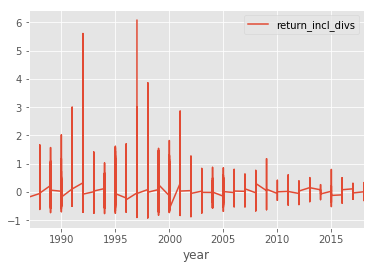

In [8]:
#plot annual returns for splits
splits_annual = splits.reset_index()[["datetime", "return_incl_divs"]]
splits_annual['year'] = splits_annual['datetime'].apply(lambda x: x.year)
splits_annual.drop("datetime", axis = 1)
splits_annual.groupby(by = "year").sum()
splits_annual.head()

splits_annual.plot(x = "year", y = "return_incl_divs")


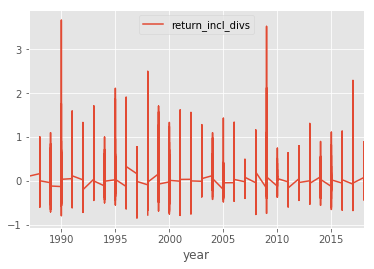

In [9]:
div_annual = dividend.reset_index()[["datetime", "return_incl_divs"]]
div_annual['year'] = div_annual['datetime'].apply(lambda x: x.year)
div_annual.drop("datetime", axis = 1)
div_annual.groupby(by = "year").sum()
div_annual.head()

div_annual.plot(x = "year", y = "return_incl_divs")

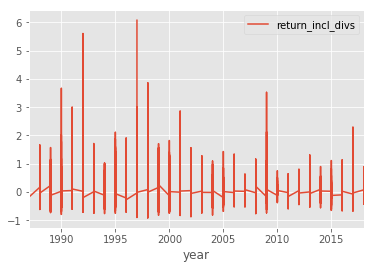

In [10]:
ds_annual = div_split.reset_index()[["datetime", "return_incl_divs"]]
ds_annual['year'] = ds_annual['datetime'].apply(lambda x: x.year)
ds_annual.drop("datetime", axis = 1)
ds_annual.groupby(by = "year").sum()
ds_annual.head()


ds_annual.plot(x = "year", y = "return_incl_divs")

In [11]:
#find the market capitalization to be used for our equally weighted portfolio
#do this for splits, dividends and splits/dividends
mcap_splits = pd.DataFrame(splits.groupby(['date'])['market_cap'].sum()).reset_index()
mcap_splits['market_cap'] = mcap_splits['market_cap']

new_splits = splits.merge(mcap_splits, on='date')
new_splits['mcap_percent'] = (new_splits['market_cap_x'] / new_splits['market_cap_y'])

new_splits['value_weighted_return'] = new_splits['mcap_percent'] * new_splits['return_incl_divs']

mcap_div = pd.DataFrame(dividend.groupby(['date'])['market_cap'].sum()).reset_index()
mcap_div['market_cap'] = mcap_div['market_cap']

new_div = dividend.merge(mcap_div, on='date')
new_div['mcap_percent'] = (new_div['market_cap_x'] / new_div['market_cap_y'])
new_div['mcap_percent'].head()

new_div['value_weighted_return'] = new_div['mcap_percent'] * new_div['return_incl_divs']

mcap_div_split = pd.DataFrame(div_split.groupby(['date'])['market_cap'].sum()).reset_index()
mcap_div_split['market_cap'] = mcap_div_split['market_cap']

new_div_split = dividend.merge(mcap_div_split, on='date')
new_div_split['mcap_percent'] = (new_div_split['market_cap_x'] / new_div_split['market_cap_y'])
new_div_split['mcap_percent'].head()

new_div_split['value_weighted_return'] = new_div_split['mcap_percent'] * new_div_split['return_incl_divs']

In [12]:
#variables for average monthly returns for different portfolios
e_d_ret = mean(dividend.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'])
e_s_ret = mean(splits.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'])
e_ds_ret = mean(div_split.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'])
v_s_ret = mean(new_splits.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'])
v_d_ret = mean(new_div.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'])
v_ds_ret = mean(new_div_split.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'])

#variables for monthly standard deviation of portfolios
e_d_std = std(dividend.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'])
e_s_std = std(splits.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'])
e_ds_std = std(div_split.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'])
v_s_std = std(new_splits.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'])
v_d_std = std(new_div.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'])
v_ds_std = std(new_div_split.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'])

#average risk free rate
e_s_rf = mean(splits.groupby(['date'])[['rf']].mean()['rf'])
e_d_rf = mean(dividend.groupby(['date'])[['rf']].mean()['rf'])
e_ds_rf = mean(div_split.groupby(['date'])[['rf']].mean()['rf'])
v_s_rf = mean(new_splits.groupby(['date'])[['rf']].mean()['rf'])
v_d_rf = mean(new_div.groupby(['date'])[['rf']].mean()['rf'])
v_ds_rf = mean(new_div_split.groupby(['date'])[['rf']].mean()['rf'])


In [13]:
#print out monthly returns
print('Equally Weighted Portfolio Average Monthly Returns for Securities that Initiated Dividends in the Past 12 Months:' + "\n" + str(e_d_ret))
print( '\nEqually Weighted Portfolio Average Monthly Returns for Securities that Initiated Dividends or Split in the Past 12 Months:' + "\n" + str(e_s_ret))
print( '\nEqually Weighted Portfolio Monthly Average Returns for Securities that Announced a Split in the Past 12 Months:' + "\n" + str(e_ds_ret))
print( '\nValue Weighted Portfolio Monthly Average Returns for Securities that Split in the Past 12 Months:' + "\n" + str(v_s_ret))
print( '\nValue Weighted Portfolio Monthly Average Returns for Securities that Initiated Dividends in the Past 12 Months:' + "\n" + str(v_d_ret))
print( '\nValue Weighted Portfolio Monthly Average Returns for Securities that Initiated Dividends or Split in the Past 12 Months:' + "\n" + str(v_ds_ret))

Equally Weighted Portfolio Average Monthly Returns for Securities that Initiated Dividends in the Past 12 Months:
0.011073807145655333

Equally Weighted Portfolio Average Monthly Returns for Securities that Initiated Dividends or Split in the Past 12 Months:
0.007940419077297698

Equally Weighted Portfolio Monthly Average Returns for Securities that Announced a Split in the Past 12 Months:
0.009365722129164067

Value Weighted Portfolio Monthly Average Returns for Securities that Split in the Past 12 Months:
0.013758967590862146

Value Weighted Portfolio Monthly Average Returns for Securities that Initiated Dividends in the Past 12 Months:
0.016594679194098357

Value Weighted Portfolio Monthly Average Returns for Securities that Initiated Dividends or Split in the Past 12 Months:
0.004959251174848821


In [14]:
#print out monthly standard deviations
print( 'Equally Weighted Portfolio Monthly Standard Deviation for Securities that Initiated Dividends in the Past 12 Months:'+ "\n" +  str(e_d_std))
print( '\nEqually Weighted Portfolio Monthly Standard Deviation for Securities that Initiated Dividends or Split in the Past 12 Months:' + "\n" + str(e_s_std))
print( '\nEqually Weighted Portfolio Monthly Standard Deviation for Securities that Announced a Split in the Past 12 Months:' + "\n" + str(e_ds_std))
print( '\nValue Weighted Portfolio Monthly Standard Deviation for Securities that Split in the Past 12 Months:' + "\n" + str(v_s_std))
print( '\nEqually Weighted Portfolio Monthly Standard Deviation for Securities that Initiated Dividends in the Past 12 Months:' + "\n" + str(v_d_std))
print( '\nEqually Weighted Portfolio Monthly Standard Deviation for Securities that Initiated Dividends or Split in the Past 12 Months:' + "\n" + str(v_ds_std))

Equally Weighted Portfolio Monthly Standard Deviation for Securities that Initiated Dividends in the Past 12 Months:
0.046727080597819166

Equally Weighted Portfolio Monthly Standard Deviation for Securities that Initiated Dividends or Split in the Past 12 Months:
0.05650506130363476

Equally Weighted Portfolio Monthly Standard Deviation for Securities that Announced a Split in the Past 12 Months:
0.05169387304576776

Value Weighted Portfolio Monthly Standard Deviation for Securities that Split in the Past 12 Months:
0.05180430079754404

Equally Weighted Portfolio Monthly Standard Deviation for Securities that Initiated Dividends in the Past 12 Months:
0.05332441294323551

Equally Weighted Portfolio Monthly Standard Deviation for Securities that Initiated Dividends or Split in the Past 12 Months:
0.019112615434619784


In [35]:
print('Sharpe Ratio of equal weighted portfolio with splits:' + "\n" + str((e_s_ret-e_s_rf)/e_s_std))
print('\nSharpe Ratio of equal weighted portfolio with dividends:' + "\n" + str((e_d_ret-e_d_rf)/e_d_std))
print('\nSharpe Ratio of equal weighted portfolio with splits and dividends: ' + "\n" + str((e_ds_ret-e_ds_rf)/e_ds_std))

print('\nSharpe Ratio of value weighted portfolio with splits:' + "\n" + str((v_s_ret-v_s_rf)/v_s_std))
print('\nSharpe Ratio of value weighted portfolio with dividends: ' + "\n" + str((v_d_ret-v_d_rf)/v_d_std))
print('\nSharpe Ratio of value weighted portfolio with splits and dividends: ' + "\n" + str((v_ds_ret-v_ds_rf)/v_ds_std))

Sharpe Ratio of equal weighted portfolio with splits:
0.09537405799819401

Sharpe Ratio of equal weighted portfolio with dividends:
0.18238899056577831

Sharpe Ratio of equal weighted portfolio with splits and dividends: 
0.13182258639815037

Sharpe Ratio of value weighted portfolio with splits:
0.21634623641248243

Sharpe Ratio of value weighted portfolio with dividends: 
0.26335736927313896

Sharpe Ratio of value weighted portfolio with splits and dividends: 
0.125987419134371


In [16]:
#to calculate the betas, we are going to perform a regression on monthly market returns and our portfolios returns

market_returns = pd.DataFrame(df1.groupby(['date'])['return_incl_divs'].mean()).reset_index()

v_split_ret = pd.DataFrame(new_splits.groupby(['date'])[['value_weighted_return']].sum()).reset_index()

v_div_ret = pd.DataFrame(new_div.groupby(['date'])[['value_weighted_return']].sum()).reset_index()

v_div_split_ret = pd.DataFrame(new_div_split.groupby(['date'])[['value_weighted_return']].sum()).reset_index()

split_ret = pd.DataFrame(splits.groupby(['date'])[['return_incl_divs']].mean()).reset_index()

div_ret = pd.DataFrame(dividend.groupby(['date'])[['return_incl_divs']].mean()).reset_index()

div_split = pd.DataFrame(div_split.groupby(['date'])[['return_incl_divs']].mean()).reset_index()

In [17]:
import statsmodels.api as sm

#average daily returns
y = market_returns['return_incl_divs']

x1 = v_split_ret['value_weighted_return']
x11 = sm.add_constant(x1)

x2 = v_div_ret['value_weighted_return']
x12 = sm.add_constant(x2)

x3 = v_div_split_ret['value_weighted_return']
x13 = sm.add_constant(x3)

x4 = split_ret['return_incl_divs']
x14 = sm.add_constant(x4)

x5 = div_ret['return_incl_divs']
x15 = sm.add_constant(x5)

x6 = div_split['return_incl_divs']
x16 = sm.add_constant(x6)

#model1 is predicting daily market returns based on the value weighted returns from the split portfolio
model1 = sm.OLS(y, x11)

#model2 is predicting daily market returns based on value weighted returns from the div portfolio
model2 = sm.OLS(y, x12)

#model3 is predicting daily market returns based on value weighted returns from the ds portfolio
model3 = sm.OLS(y, x13)

#model4 is predicting daily market returns based on equal weighted returns from the split portfolio
model4 = sm.OLS(y, x14)

#model5 is predicting daily market returns based on equal weighted returns from the div portfolio
model5 = sm.OLS(y, x15)

#model6 is predicting daily market returns based on equal weighted returns from the ds portfolio
model6 = sm.OLS(y, x16)


results1 = model1.fit()
print(results1.summary())

results2 = model2.fit()
print(results2.summary())

results3 = model3.fit()
print(results3.summary())

results4 = model4.fit()
print(results4.summary())

results5 = model5.fit()
print(results5.summary())

results6 = model6.fit()
print(results6.summary())

                            OLS Regression Results                            
Dep. Variable:       return_incl_divs   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     520.9
Date:                Fri, 11 Oct 2019   Prob (F-statistic):           2.40e-73
Time:                        20:02:56   Log-Likelihood:                 722.18
No. Observations:                 384   AIC:                            -1440.
Df Residuals:                     382   BIC:                            -1432.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

C:\Users\19785\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [18]:
results1.params

const                   -0.000829
value_weighted_return    0.831680
dtype: float64

In [19]:
alpha1 = mean(v_split_ret)[0] - 0.7113*(mean(market_returns)[0])

alpha2 = mean(v_div_ret)[0] - 0.7670*(mean(market_returns)[0])

alpha3 = mean(v_div_split_ret)[0] - 0.8799*(mean(market_returns)[0])

alpha4 = mean(split_ret)[0] - 1.1878*(mean(market_returns)[0])

alpha5 = mean(div_ret)[0] - 0.8627*(mean(market_returns)[0])

alpha6 = mean(div_split)[0] - 1.0426*(mean(market_returns)[0])

print(alpha1)
print(alpha2)
print(alpha3)
print(alpha4)
print(alpha5)
print(alpha6)

0.006209416933265357
0.008453943422445416
-0.004379775429424221
-0.004666576945608902
0.0019173368064050178
-0.0017001593773878967


In [20]:
#create dataframe for splits, dividends and both
mask = (df1['rolling_split'] >= 1)
dividend = df1[mask]
 
mask1 = (df1['rolling_div'] >= 1)
splits = df1[mask1]

df1['div_split'] = df1['rolling_div'] + df1['rolling_split']

mask2 = (df1['div_split'] >=1)
div_split = df1[mask2]

counts1 = splits['stock_id'].value_counts()
splits = splits[splits['stock_id'].isin(counts1[counts1 >= 12].index)]

counts2 = dividend['stock_id'].value_counts()
dividend = dividend[dividend['stock_id'].isin(counts2[counts2 >= 12].index)]

counts3 = div_split['stock_id'].value_counts()
div_split = div_split[div_split['stock_id'].isin(counts3[counts3 >= 12].index)]

In [21]:
#variables for average monthly returns for different portfolios 1st half
e_d_ret1 = mean(dividend.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][:192])
e_s_ret1 = mean(splits.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][:192])
e_ds_ret1 = mean(div_split.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][:192])
v_s_ret1 = mean(new_splits.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][:192])
v_d_ret1 = mean(new_div.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][:192])
v_ds_ret1 = mean(new_div_split.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][:192])

#variables for monthly standard deviation of portfolios 1st half
e_d_std1 = std(dividend.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][:192])
e_s_std1 = std(splits.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][:192])
e_ds_std1 = std(div_split.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][:192])
v_s_std1 = std(new_splits.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][:192])
v_d_std1 = std(new_div.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][:192])
v_ds_std1 = std(new_div_split.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][:192])

#average risk free rate 1st half
e_s_rf1 = mean(splits.groupby(['date'])[['rf']].mean()['rf'][:192])
e_d_rf1 = mean(dividend.groupby(['date'])[['rf']].mean()['rf'][:192])
e_ds_rf1 = mean(div_split.groupby(['date'])[['rf']].mean()['rf'][:192])
v_s_rf1 = mean(new_splits.groupby(['date'])[['rf']].mean()['rf'][:192])
v_d_rf1 = mean(new_div.groupby(['date'])[['rf']].mean()['rf'][:192])
v_ds_rf1 = mean(new_div_split.groupby(['date'])[['rf']].mean()['rf'][:192])


In [34]:
#1st half sharpe ratios for all portfolios

print('Sharpe Ratio of equal weighted portfolio with splits from 1987-2002:' + "\n" + str((e_s_ret1-e_s_rf1)/e_s_std1))
print('\n\nSharpe Ratio of equal weighted portfolio with dividends from 1987-2002:' +"\n"+str((e_d_ret1-e_d_rf1)/e_d_std1))
print('\n\nSharpe Ratio of equal weighted portfolio with splits and dividends from 1987-2002: ' + "\n" + str((e_ds_ret1-e_ds_rf1)/e_ds_std1))

print('\n\nSharpe Ratio of value weighted portfolio with splits from 1987-2002:' +"\n"+str((v_s_ret1-v_s_rf1)/v_s_std1))
print('\n\nSharpe Ratio of value weighted portfolio with dividends from 1987-2002: ' + "\n" + str((v_d_ret1-v_d_rf1)/v_d_std1))
print('\n\nSharpe Ratio of value weighted portfolio with splits and dividends from 1987-2002:' +"\n"+str((v_ds_ret1-v_ds_rf1)/v_ds_std1))

Sharpe Ratio of equal weighted portfolio with splits from 1987-2002:
0.1662473545338687


Sharpe Ratio of equal weighted portfolio with dividends from 1987-2002:
0.02914521046710048


Sharpe Ratio of equal weighted portfolio with splits and dividends from 1987-2002: 
0.0716335587127531


Sharpe Ratio of value weighted portfolio with splits from 1987-2002:
0.19078049112043627


Sharpe Ratio of value weighted portfolio with dividends from 1987-2002: 
0.28567303527020693


Sharpe Ratio of value weighted portfolio with splits and dividends from 1987-2002:
-0.16786112926168315


In [24]:
#variables for average monthly returns for different portfolios 2nd half
e_d_ret2 = mean(dividend.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][191:])
e_s_ret2 = mean(splits.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][191:])
e_ds_ret2 = mean(div_split.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][191:])
v_s_ret2 = mean(new_splits.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][191:])
v_d_ret2 = mean(new_div.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][191:])
v_ds_ret2 = mean(new_div_split.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][191:])

#variables for monthly standard deviation of portfolios 2nd half
e_d_std2 = std(dividend.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][191:])
e_s_std2 = std(splits.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][191:])
e_ds_std2 = std(div_split.groupby(['date'])[['return_incl_divs']].mean()['return_incl_divs'][191:])
v_s_std2 = std(new_splits.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][191:])
v_d_std2 = std(new_div.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][191:])
v_ds_std2 = std(new_div_split.groupby(['date'])[['value_weighted_return']].sum()['value_weighted_return'][191:])

#average risk free rate 2nd half
e_s_rf2 = mean(splits.groupby(['date'])[['rf']].mean()['rf'][191:])
e_d_rf2 = mean(dividend.groupby(['date'])[['rf']].mean()['rf'][191:])
e_ds_rf2 = mean(div_split.groupby(['date'])[['rf']].mean()['rf'][191:])
v_s_rf2 = mean(new_splits.groupby(['date'])[['rf']].mean()['rf'][191:])
v_d_rf2 = mean(new_div.groupby(['date'])[['rf']].mean()['rf'][191:])
v_ds_rf2 = mean(new_div_split.groupby(['date'])[['rf']].mean()['rf'][191:])

In [33]:
#2nd half sharpe ratios for all portfolios

print('Sharpe Ratio of equal weighted portfolio with splits from 2003-2018:' + "\n" + str((e_s_ret2-e_s_rf2)/e_s_std2))
print('\nSharpe Ratio of equal weighted portfolio with dividends from 2003-2018:'+"\n"+str((e_d_ret2-e_d_rf2)/e_d_std2))
print('\nSharpe Ratio of equal weighted portfolio with splits and dividends from 2003-2018: ' + "\n" + str((e_ds_ret2-e_ds_rf2)/e_ds_std2))

print('\nSharpe Ratio of value weighted portfolio with splits from 2003-2018:' + "\n" + str((v_s_ret2-v_s_rf2)/v_s_std2))
print('\nSharpe Ratio of value weighted portfolio with dividends from 2003-2018: '+"\n"+str((v_d_ret2-v_d_rf2)/v_d_std2))
print('\nSharpe Ratio of value weighted portfolio with splits and dividends from 2003-2018: ' +"\n"+str((v_ds_ret2-v_ds_rf2)/v_ds_std2))

Sharpe Ratio of equal weighted portfolio with splits from 2003-2018:
0.19593892028590557

Sharpe Ratio of equal weighted portfolio with dividends from 2003-2018:
0.17902547133400207

Sharpe Ratio of equal weighted portfolio with splits and dividends from 2003-2018: 
0.1984550331962336

Sharpe Ratio of value weighted portfolio with splits from 2003-2018:
0.24690368770096796

Sharpe Ratio of value weighted portfolio with dividends from 2003-2018: 
0.24101395257274905

Sharpe Ratio of value weighted portfolio with splits and dividends from 2003-2018: 
0.24560936010726386
